## POS tagging using modified Viterbi

- Name: Ragesh Hajela
- Applicant ID : APFE19704533
- Roll Number  : DML1980177

### Data Preparation

In [1]:
# Importing libraries
import nltk
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

In [2]:
# Reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
# check data type of nltk_data and print first 2 elements
print(type(nltk_data))
nltk_data[:2]

<class 'list'>


[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')]]

In [4]:
# we split the Treebank dataset into train and validation sets.
# As advised, we use a sample size of 95:5 for training: validation sets,
# i.e. keep the validation size small, else the algorithm will need a very high amount of runtime.
# Split and check size of train/test data and print first 2 elements of training sample
random.seed(100)
nltk_train, nltk_test = train_test_split(nltk_data, test_size=0.05)

print(f'length of training dataset:\t{len(nltk_train)}')
print(f'length of test dataset:\t\t{len(nltk_test)}')
nltk_train[:2]

length of training dataset:	3718
length of test dataset:		196


[[('A', 'DET'),
  ('man', 'NOUN'),
  ('from', 'ADP'),
  ('the', 'DET'),
  ('Bush', 'NOUN'),
  ('administration', 'NOUN'),
  ('came', 'VERB'),
  ('before', 'ADP'),
  ('the', 'DET'),
  ('House', 'NOUN'),
  ('Agriculture', 'NOUN'),
  ('Committee', 'NOUN'),
  ('yesterday', 'NOUN'),
  ('*-1', 'X'),
  ('to', 'PRT'),
  ('talk', 'VERB'),
  ('about', 'ADP'),
  ('the', 'DET'),
  ('U.S.', 'NOUN'),
  ("'s", 'PRT'),
  ('intention', 'NOUN'),
  ('*', 'X'),
  ('to', 'PRT'),
  ('send', 'VERB'),
  ('some', 'DET'),
  ('$', '.'),
  ('100', 'NUM'),
  ('million', 'NUM'),
  ('*U*', 'X'),
  ('in', 'ADP'),
  ('food', 'NOUN'),
  ('aid', 'NOUN'),
  ('to', 'PRT'),
  ('Poland', 'NOUN'),
  (',', '.'),
  ('with', 'ADP'),
  ('more', 'ADJ'),
  ('0', 'X'),
  ('*T*-2', 'X'),
  ('to', 'PRT'),
  ('come', 'VERB'),
  ('from', 'ADP'),
  ('the', 'DET'),
  ('EC', 'NOUN'),
  ('.', '.')],
 [('But', 'CONJ'),
  ('in', 'ADP'),
  ('August', 'NOUN'),
  (',', '.'),
  ('First', 'ADJ'),
  ('Atlanta', 'NOUN'),
  ('National', 'NOUN'),
  (

In [5]:
# Get the complete list of tagged words in training set and print first 10 elements of tagged words in training data
nltk_train_tagged_words = [el for sublist in nltk_train for el in sublist]
print(f'length of list containing tagged words of training dataset: {len(nltk_train_tagged_words)}')
nltk_train_tagged_words[:10]

length of list containing tagged words of training dataset: 95396


[('A', 'DET'),
 ('man', 'NOUN'),
 ('from', 'ADP'),
 ('the', 'DET'),
 ('Bush', 'NOUN'),
 ('administration', 'NOUN'),
 ('came', 'VERB'),
 ('before', 'ADP'),
 ('the', 'DET'),
 ('House', 'NOUN')]

In [6]:
# Fetch all the tokens available in tagged words of training dataset and print first 10 tagged words
nltk_train_tokens = [el[0] for el in nltk_train_tagged_words]
print(f'length of list containing tokens or words of training dataset: {len(nltk_train_tokens)}')
nltk_train_tokens[:10]

length of list containing tokens or words of training dataset: 95396


['A',
 'man',
 'from',
 'the',
 'Bush',
 'administration',
 'came',
 'before',
 'the',
 'House']

In [7]:
# Get all the unique vocabularies from word token extracted from training sample dataset and print first 10 elements
nltk_train_vocab = set(nltk_train_tokens)
print(f'Unique number of tokens or words present in training dataset: {len(nltk_train_vocab)}')

Unique number of tokens or words present in training dataset: 12027


In [8]:
# Get the number of unique tags among tagged words in training dataset and print all of them
nltk_train_tags = {el[1] for el in nltk_train_tagged_words}
print(f'Unique number of tags present in training dataset: {len(nltk_train_tags)}')
nltk_train_tags

Unique number of tags present in training dataset: 12


{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

As seen above, we confirm that the Universal tagset of NLTK used in this assignment comprises only 12 coarse tag classes as follows: Verb, Noun, Pronouns, Adjectives, Adverbs, Adpositions, Conjunctions, Determiners, Cardinal Numbers, Particles, Other/ Foreign words, Punctuations.

### Build the vanilla Viterbi based POS tagger

#### Helper Methods

In [9]:
# Emission Probability: get counts to compute emission probability of a word given it's tag
def get_emission_prob(word, target_tag, source_data = nltk_train_tagged_words):
    tag_list = [tag_pair for tag_pair in source_data if tag_pair[1] == target_tag]
    tag_with_word_list = [tag_pair[0] for tag_pair in tag_list if tag_pair[0] == word]
    return (len(tag_with_word_list), len(tag_list))

In [10]:
# Transition Probability: get counts to compute transition prabability of a final tag given start tag
def get_transition_prob(final_state, start_state, source_data = nltk_train_tagged_words):
    all_tags = [pair[1] for pair in source_data]
    start_count = len([t for t in all_tags if t==start_state])
    transition_count = 0
    for idx in range(len(all_tags)-1):
        if all_tags[idx] == start_state and all_tags[idx+1] == final_state:
            transition_count += 1
    return (transition_count, start_count)

#### Tagger Building

In [11]:
# Build the initial matrix of all tags using transition probabilities
prob_array = np.zeros((len(nltk_train_tags), len(nltk_train_tags)), dtype='float32')
for idx_i, tag_init in enumerate(list(nltk_train_tags)):
    for idx_j, tag_final in enumerate(list(nltk_train_tags)):
        prob_array[idx_i, idx_j] = get_transition_prob(tag_final, tag_init)[0] / get_transition_prob(tag_final,
                                                                                                     tag_init)[1]
print(f'shape of probability array is: {prob_array.shape}')
prob_array

shape of probability array is: (12, 12)


array([[6.62130788e-02, 6.63790270e-04, 2.07434446e-02, 1.69266518e-02,
        4.97842673e-03, 1.21141719e-02, 6.48854971e-02, 6.99634910e-01,
        1.06206443e-02, 2.07434446e-02, 7.78294057e-02, 4.64653177e-03],
       [7.16762990e-02, 7.32177263e-03, 7.70712923e-03, 5.00963395e-03,
        9.24855471e-03, 4.87861276e-01, 4.20038551e-02, 2.09248558e-01,
        1.19460505e-02, 9.09441262e-02, 2.35067438e-02, 3.35260108e-02],
       [3.41956578e-02, 1.18941418e-03, 1.87332734e-01, 1.36782639e-02,
        3.56824254e-03, 1.75438598e-02, 1.16859950e-01, 3.52661312e-01,
        2.70591732e-02, 2.08147481e-01, 3.44930105e-02, 3.27088917e-03],
       [1.14030972e-01, 5.77193797e-02, 4.12951671e-02, 4.69263265e-04,
        1.21539183e-01, 1.56264663e-01, 3.51947434e-02, 3.52416694e-01,
        4.69263270e-03, 8.91600177e-03, 5.34960106e-02, 5.39652742e-02],
       [2.04288125e-01, 3.61358700e-03, 2.19224282e-02, 4.81811614e-04,
        5.29992767e-03, 3.92676480e-02, 1.73452180e-02, 6.40

In [12]:
# Create the initial dataframe for all training tags
nltk_tags_df = pd.DataFrame(prob_array, columns = list(nltk_train_tags), index=list(nltk_train_tags))
print(nltk_tags_df.loc['.', :])
nltk_tags_df

ADJ     0.044225
PRON    0.066157
NUM     0.080629
CONJ    0.057978
DET     0.174652
VERB    0.090067
.       0.094112
NOUN    0.217798
PRT     0.002427
X       0.027955
ADP     0.090966
ADV     0.052944
Name: ., dtype: float32


,ADJ,PRON,NUM,CONJ,DET,VERB,.,NOUN,PRT,X,ADP,ADV
ADJ,0.066213,0.000664,0.020743,0.016927,0.004978,0.012114,0.064885,0.699635,0.010621,0.020743,0.077829,0.004647
PRON,0.071676,0.007322,0.007707,0.005010,0.009249,0.487861,0.042004,0.209249,0.011946,0.090944,0.023507,0.033526
NUM,0.034196,0.001189,0.187333,0.013678,0.003568,0.017544,0.116860,0.352661,0.027059,0.208147,0.034493,0.003271
CONJ,0.114031,0.057719,0.041295,0.000469,0.121539,0.156265,0.035195,0.352417,0.004693,0.008916,0.053496,0.053965
DET,0.204288,0.003614,0.021922,0.000482,0.005300,0.039268,0.017345,0.640689,0.000241,0.044688,0.009395,0.012768
VERB,0.063916,0.035734,0.022265,0.005450,0.134371,0.167380,0.035656,0.111172,0.031608,0.218529,0.091942,0.081977
.,0.044225,0.066157,0.080629,0.057978,0.174652,0.090067,0.094112,0.217798,0.002427,0.027955,0.090966,0.052944
NOUN,0.012114,0.004648,0.009443,0.042199,0.013212,0.147458,0.239688,0.264466,0.043736,0.028438,0.177470,0.017128
PRT,0.081827,0.018074,0.057180,0.001972,0.102859,0.400920,0.041735,0.249425,0.001972,0.013802,0.020375,0.009859
X,0.017409,0.054784,0.002875,0.009903,0.054943,0.204760,0.166747,0.059415,0.184475,0.075866,0.142948,0.025874


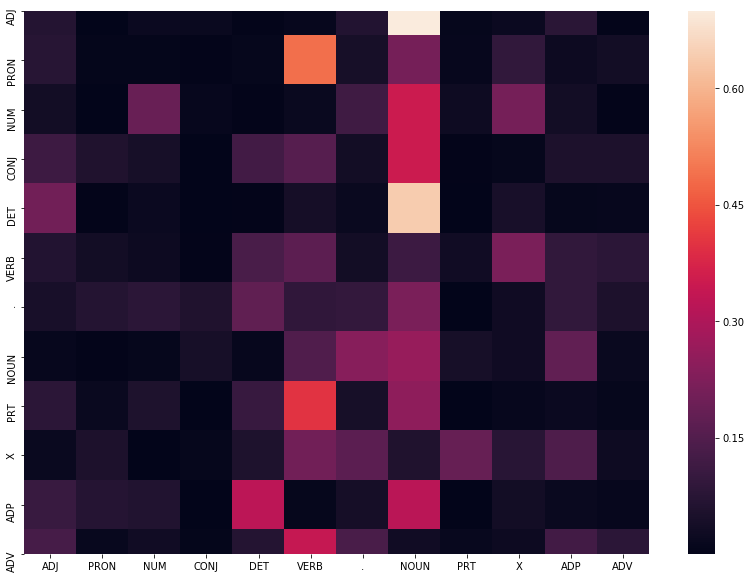

In [13]:
# Visualise nltk_tags_df matrix using heatmap. Here, P(i, j) means P(tag j given tag i)
plt.figure(figsize=(14, 10))
sns.heatmap(nltk_tags_df)
plt.show()

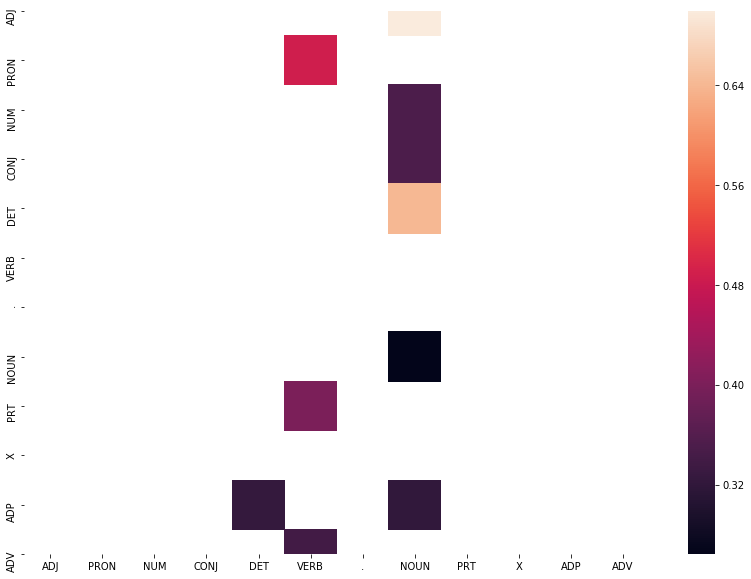

In [14]:
# Visualise nltk_tags_df matrix using heatmap and filter to get P(final_state, start_state) > 0.25
nltk_tags_filtered_df = nltk_tags_df[nltk_tags_df > 0.25]
plt.figure(figsize=(14, 10))
sns.heatmap(nltk_tags_filtered_df)
plt.show()

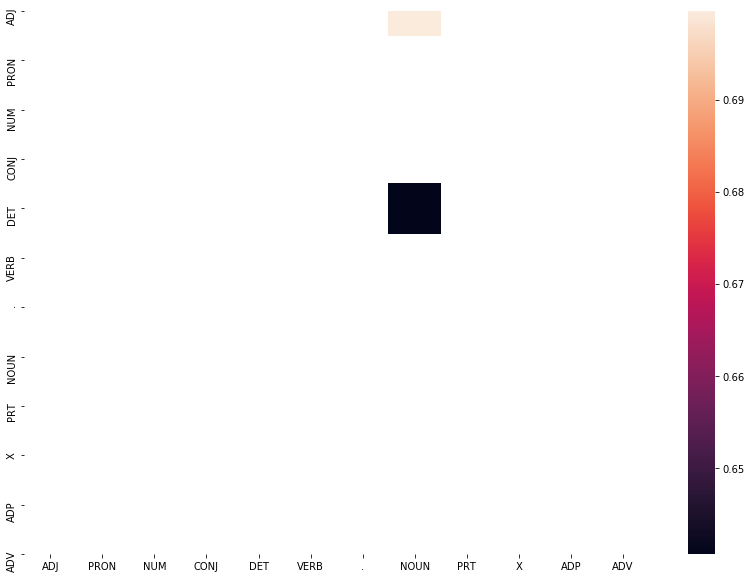

In [15]:
# Visualise nltk_tags_df matrix using heatmap and filter to get P(final_state, start_state) > 0.50
nltk_tags_filtered_df = nltk_tags_df[nltk_tags_df > 0.50]
plt.figure(figsize=(14, 10))
sns.heatmap(nltk_tags_filtered_df)
plt.show()

We observe, as expected, Noun and Determinent & Noun and Adjective are highly correlated. Mostly Nouns are followed by determinents and adjectives

In [16]:
# Viterbi Heuristic: Build the vanilla Viterbi based POS tagger by computing emission and state probabilities
# Initialise list of probability column for a given observation and then get state for which probability is maximum
def execute_viterbi(words, source_data = nltk_train_tagged_words):
    state_list = []
    tag_list = list(set([el[1] for el in source_data]))
    for idx, word in enumerate(words):
        word_prob = []
        for tag in tag_list:
            state_prob, transition_prob, emission_prob = None, None, None
            if idx == 0:
                transition_prob = nltk_tags_df.loc['.', tag]
            else:
                transition_prob = nltk_tags_df.loc[state_list[-1], tag]
            emission_prob = get_emission_prob(words[idx], tag)[0]/get_emission_prob(words[idx], tag)[1]
            word_prob.append(emission_prob * transition_prob)
        state_max_prob = tag_list[word_prob.index(max(word_prob))] 
        state_list.append(state_max_prob)
    return list(zip(words, state_list))

In [17]:
# Algorithm runtime on the full test data is taking too long, so restricting to few samples only
# Execute Viterbi algorithm on first 10 sample sentences of test dataset chosen randomly
# Let the list of tagged and untagged words and print list of all sentences
random.seed(100)
random_samples = [random.randint(1,len(nltk_test)) for x in range(10)]
random_test_sentences = [nltk_test[i] for i in random_samples]

test_tagged_words = [tup for sentence in random_test_sentences for tup in sentence]
test_untagged_words = [tup[0] for sentence in random_test_sentences for tup in sentence]
random_test_sentences[:2]

[[('Many', 'ADJ'),
  ('Asians', 'NOUN'),
  ('regard', 'VERB'),
  ('a', 'DET'),
  ('U.S.', 'NOUN'),
  ('presence', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('desirable', 'ADJ'),
  ('counterweight', 'NOUN'),
  ('to', 'PRT'),
  ('Japanese', 'ADJ'),
  ('influence', 'NOUN'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Cray', 'NOUN'),
  (',', '.'),
  ('who', 'PRON'),
  ('*T*-1', 'X'),
  ('could', 'VERB'),
  ("n't", 'ADV'),
  ('be', 'VERB'),
  ('reached', 'VERB'),
  ('*-24', 'X'),
  ('for', 'ADP'),
  ('comment', 'NOUN'),
  (',', '.'),
  ('will', 'VERB'),
  ('work', 'VERB'),
  ('for', 'ADP'),
  ('the', 'DET'),
  ('new', 'ADJ'),
  ('Colorado', 'NOUN'),
  ('Springs', 'NOUN'),
  (',', '.'),
  ('Colo.', 'NOUN'),
  (',', '.'),
  ('company', 'NOUN'),
  ('as', 'ADP'),
  ('an', 'DET'),
  ('independent', 'ADJ'),
  ('contractor', 'NOUN'),
  ('--', '.'),
  ('the', 'DET'),
  ('arrangement', 'NOUN'),
  ('0', 'X'),
  ('he', 'PRON'),
  ('had', 'VERB'),
  ('*T*-2', 'X'),
  ('with', 'ADP'),
  ('Cray', 'NOUN'),
  

#### Execute tagging

In [18]:
%%time
# Start tagging the test sentences using execute_viterbi algorithm and get the accuracy
tagged_sequence = execute_viterbi(test_untagged_words)
tagged_sequence[:10]

CPU times: user 49.3 s, sys: 168 ms, total: 49.5 s
Wall time: 49.6 s


[('Many', 'ADJ'),
 ('Asians', 'ADJ'),
 ('regard', 'VERB'),
 ('a', 'DET'),
 ('U.S.', 'NOUN'),
 ('presence', 'NOUN'),
 ('as', 'ADP'),
 ('a', 'DET'),
 ('desirable', 'ADJ'),
 ('counterweight', 'ADJ')]

#### Evaluating tagging accuracy

In [19]:
# Get the accuracy of vannila viterbi algorithm
source = [sequence for sequence, word_tag in zip(tagged_sequence, test_tagged_words) if sequence == word_tag] 
accuracy_vannila_viterbi = len(source)/len(tagged_sequence)
print(f'accuracy of vannila viterbi algorithm is: {accuracy_vannila_viterbi}')

accuracy of vannila viterbi algorithm is: 0.8960573476702509


In [20]:
# Get all the incorrect tagged words
incorrect_tagged_words = [[test_tagged_words[idx-1], seq_to_check]
                          for idx, seq_to_check in enumerate(zip(tagged_sequence, test_tagged_words))
                          if seq_to_check[0] != seq_to_check[1]]
incorrect_tagged_words

[[('Many', 'ADJ'), (('Asians', 'ADJ'), ('Asians', 'NOUN'))],
 [('desirable', 'ADJ'), (('counterweight', 'ADJ'), ('counterweight', 'NOUN'))],
 [('new', 'ADJ'), (('Colorado', 'ADJ'), ('Colorado', 'NOUN'))],
 [('.', '.'), (('Pan', 'ADJ'), ('Pan', 'NOUN'))],
 [('Pan', 'NOUN'), (('Am', 'ADJ'), ('Am', 'VERB'))],
 [('has', 'VERB'), (('subpoenaed', 'ADJ'), ('subpoenaed', 'VERB'))],
 [('the', 'DET'), (('CIA', 'ADJ'), ('CIA', 'NOUN'))],
 [('and', 'CONJ'), (('FBI', 'ADJ'), ('FBI', 'NOUN'))],
 [('a', 'DET'), (('bomb', 'ADJ'), ('bomb', 'NOUN'))],
 [('been', 'VERB'), (('planted', 'ADJ'), ('planted', 'VERB'))],
 [('*-2', 'X'), (('aboard', 'ADJ'), ('aboard', 'ADP'))],
 [('jet', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('*T*-3', 'X'), (('exploded', 'ADJ'), ('exploded', 'VERB'))],
 [('over', 'ADP'), (('Scotland', 'ADJ'), ('Scotland', 'NOUN'))],
 [('the', 'DET'), (('reorganized', 'ADJ'), ('reorganized', 'VERB'))],
 [('*-1', 'X'), (('Ranger', 'ADJ'), ('Ranger', 'NOUN'))],
 [('The', 'DET'), (('most'

### Solve the problem of unknown words

#### Check Test File

In [21]:
# Load test file test_sentences.txt and print all the lines of the test file
test_sentences = []
with open("Test_sentences.txt", encoding='utf-8') as file_obj:
    for line in file_obj:
        print(line)
        test_sentences.append(line)
test_sentences

Android is a mobile operating system developed by Google.

Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.

Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.

Twitter is an online news and social networking service on which users post and interact with messages known as tweets.

Before entering politics, Donald Trump was a domineering businessman and a television personality.

The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.

This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.

Show me the cheapest round trips from Dallas to Atlanta

I would like to see flights from Denver to Philadelphia.

Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.

NASA invited social media users to experience the launch of ICESAT-2 Satelli

['Android is a mobile operating system developed by Google.\n',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.\n',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.\n",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.\n',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.\n',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.\n',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.\n',
 'Show me the cheapest round trips from Dallas to Atlanta\n',
 'I would like to see flights from Denver to Philadelphia.\n',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.\n',
 'NASA invited social medi

In [22]:
# Cleanup special characters like newline and empty strings in the test file
test_sentences = [sentence.rstrip() for sentence in test_sentences if sentence.rstrip()!='']
test_sentences

['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
 'Show me the cheapest round trips from Dallas to Atlanta',
 'I would like to see flights from Denver to Philadelphia.',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
 'NASA invited social media users to experienc

In [23]:
%%time
# Perform word_tokenize on test sentences, execute vanilla viterbi algorithm
# This helps to get predictions on the test sentences.
test_sentences_pred = []
for sentence in test_sentences:
    test_sentences_pred.extend(execute_viterbi(word_tokenize(sentence)))
print(test_sentences_pred)

[('Android', 'ADJ'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'ADJ'), ('.', '.'), ('Android', 'ADJ'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'ADJ'), ('worldwide', 'ADJ'), ('on', 'ADP'), ('smartphones', 'ADJ'), ('since', 'ADP'), ('2011', 'ADJ'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'ADJ'), ('.', '.'), ('Google', 'ADJ'), ('and', 'CONJ'), ('Twitter', 'ADJ'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'ADJ'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'ADJ'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'ADJ'), ("'s", 'PRT'), ('firehose', 'ADJ'), ('.', '.'), ('Twitter', 'ADJ'), ('is', 'VERB'), ('an', 'DET'), ('online', 'ADJ'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOU

In [24]:
# Get the tokens in test file & list of words which are present in test file but not in the training corpus
# This will help us to extract all the words not present in corpus and examine how the unknown words are tagged
sample_tokens = [token for sentence in test_sentences for token in word_tokenize(sentence)]
words_not_in_corpus = list(set(sample_tokens) - set(nltk_train_tokens))
print(words_not_in_corpus)

wrongly_tagged_words = [pair for pair in test_sentences_pred for word in words_not_in_corpus if pair[0] == word]
wrongly_tagged_words

['Satellite', 'smartphones', 'tournament', 'Google', 'ICESAT-2', 'trips', 'interact', 'OS', '2018', '21st', 'invited', 'Android', '2013', 'tweets', '2015', 'domineering', 'worldwide', 'online', 'arriving', 'Denver', 'Cup', 'contested', 'FIFA', 'firehose', 'Twitter', 'messages', '2011', 'personality', 'NASA']


[('Android', 'ADJ'),
 ('Google', 'ADJ'),
 ('Android', 'ADJ'),
 ('OS', 'ADJ'),
 ('worldwide', 'ADJ'),
 ('smartphones', 'ADJ'),
 ('2011', 'ADJ'),
 ('2013', 'ADJ'),
 ('Google', 'ADJ'),
 ('Twitter', 'ADJ'),
 ('2015', 'ADJ'),
 ('Google', 'ADJ'),
 ('Twitter', 'ADJ'),
 ('firehose', 'ADJ'),
 ('Twitter', 'ADJ'),
 ('online', 'ADJ'),
 ('interact', 'ADJ'),
 ('messages', 'ADJ'),
 ('tweets', 'ADJ'),
 ('domineering', 'ADJ'),
 ('personality', 'ADJ'),
 ('2018', 'ADJ'),
 ('FIFA', 'ADJ'),
 ('Cup', 'ADJ'),
 ('21st', 'ADJ'),
 ('FIFA', 'ADJ'),
 ('Cup', 'ADJ'),
 ('tournament', 'ADJ'),
 ('contested', 'ADJ'),
 ('Cup', 'ADJ'),
 ('trips', 'ADJ'),
 ('Denver', 'ADJ'),
 ('arriving', 'ADJ'),
 ('NASA', 'ADJ'),
 ('invited', 'ADJ'),
 ('ICESAT-2', 'ADJ'),
 ('Satellite', 'ADJ')]

We observe that words like 'Google', 'Twitter' and 'Android' etc. are not present in the training set and they are all tagged default tags using vanilla viterbi algorithm

#### Perform EDA

In [25]:
# Check count of all tags in the training set and top 5 tag counts
train_tag_counts = Counter(pair[1] for pair in nltk_train_tagged_words)
print(train_tag_counts)
train_tag_counts.most_common(5)

Counter({'NOUN': 27323, 'VERB': 12845, '.': 11125, 'ADP': 9362, 'DET': 8302, 'X': 6261, 'ADJ': 6026, 'NUM': 3363, 'PRT': 3043, 'ADV': 3020, 'PRON': 2595, 'CONJ': 2131})


[('NOUN', 27323), ('VERB', 12845), ('.', 11125), ('ADP', 9362), ('DET', 8302)]

In [26]:
# Check count of incorrectly classfied words tags
Counter(pair[1][0][1] for pair in incorrect_tagged_words)

Counter({'ADJ': 27, 'ADP': 2})

In [27]:
# Check the percentage of words classified as verbs which end with 'ed'
# We observe 20% words have been classified as verb, and have word ending with "ed"
tagged_verb = [pair for pair in nltk_train_tagged_words if pair[1] == 'VERB']
verb_ed = [pair for pair in tagged_verb if pair[0].endswith('ed')]
print(f'Percentage of words ending with "ed" tagged as verb: {round((len(verb_ed) / len(tagged_verb))*100, 2)}')
verb_ed[:10]

Percentage of words ending with "ed" tagged as verb: 20.7


[('introduced', 'VERB'),
 ('designed', 'VERB'),
 ('fielded', 'VERB'),
 ('tried', 'VERB'),
 ('warned', 'VERB'),
 ('lowered', 'VERB'),
 ('alleged', 'VERB'),
 ('filed', 'VERB'),
 ('issued', 'VERB'),
 ('merged', 'VERB')]

In [28]:
# Check the percentage of words classified as verbs which end with 'ing'
# We observe ~11% words have been classified as verb, and have word ending with "ed"
tagged_verb = [pair for pair in nltk_train_tagged_words if pair[1] == 'VERB']
verb_ing = [pair for pair in tagged_verb if pair[0].endswith('ing')]
print(f'Percentage of words ending with "ing" tagged as verb: {round((len(verb_ing) / len(tagged_verb))*100, 2)}')
verb_ing[:10]

Percentage of words ending with "ing" tagged as verb: 10.91


[('packaging', 'VERB'),
 ('accusing', 'VERB'),
 ('jeopardizing', 'VERB'),
 ('raising', 'VERB'),
 ('including', 'VERB'),
 ('yielding', 'VERB'),
 ('tracking', 'VERB'),
 ('bring', 'VERB'),
 ('surrounding', 'VERB'),
 ('reporting', 'VERB')]

In [29]:
# Check the percentage of words classified as verbs which end with 'es'
# We observe ~2.5% words have been classified as verb, and have word ending with "es"
tagged_verb = [pair for pair in nltk_train_tagged_words if pair[1] == 'VERB']
verb_es = [pair for pair in tagged_verb if pair[0].endswith('es')]
print(f'Percentage of words ending with "es" tagged as verb: {round((len(verb_es) / len(tagged_verb))*100, 2)}')
verb_es[:10]

Percentage of words ending with "es" tagged as verb: 2.6


[('states', 'VERB'),
 ('believes', 'VERB'),
 ('faces', 'VERB'),
 ('goes', 'VERB'),
 ('hopes', 'VERB'),
 ('compares', 'VERB'),
 ('becomes', 'VERB'),
 ('pushes', 'VERB'),
 ('concedes', 'VERB'),
 ('improves', 'VERB')]

In [30]:
# Check the percentage of words classified as adjective tags and are followed by Noun
# We observe ~70% words have been classified as adjective and are followed by a Noun
all_tags = [pair[1] for pair in nltk_train_tagged_words]
tagged_adj = [tag for tag in all_tags if tag == 'ADJ']
adj_noun = [(tag, all_tags[idx+1]) for idx, tag in enumerate(all_tags) if tag == 'ADJ' and all_tags[idx+1] == 'NOUN']
print(f'Percentage of words tagged as adjective followed by noun: {round((len(adj_noun) / len(tagged_adj))*100, 2)}')

Percentage of words tagged as adjective followed by noun: 69.96


In [31]:
# Check the percentage of words classified as determinent tags and are followed by Noun
# We observe ~64% words have been classified as determinent and are followed by a Noun
all_tags = [pair[1] for pair in nltk_train_tagged_words]
tagged_det = [tag for tag in all_tags if tag == 'DET']
adj_noun = [(tag, all_tags[idx+1]) for idx, tag in enumerate(all_tags) if tag == 'DET' and all_tags[idx+1] == 'NOUN']
print(f'Percentage of words taggedas determinent followed by noun: {round((len(adj_noun) / len(tagged_det))*100, 2)}')

Percentage of words taggedas determinent followed by noun: 64.07


In [32]:
# Based on the EDA done above designing the pattern for tagging for further algorithms
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense verbs
    (r'.*es$', 'VERB'),               # singular present verbs
    (r'.*ould$', 'VERB'),              # modal verbs
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'(The|the|A|a|An|an)$', 'DET'),   # articles or determinants
    (r'.*able$', 'ADJ'),                # adjectives
    (r'.*ness$', 'NOUN'),                # nouns formed from adjectives
    (r'.*ly$', 'ADV'),                  # adverbs
    (r'.*', 'NOUN')                    # nouns
]

#### Approach 1: Rule Based Tagging with Viterbi using backoff

In [33]:
# Apply rule based tagger using regex and unigram tagger
rule_based_tagger = nltk.RegexpTagger(patterns)
rule_based_lexicon_tagger = nltk.UnigramTagger(nltk_train, backoff = rule_based_tagger)
accuracy_rule_based_viterbi_backoff = rule_based_lexicon_tagger.evaluate(nltk_test)
print(f'accuracy of rule based viterbi algorithm using backoff is: {accuracy_rule_based_viterbi_backoff}')

accuracy of rule based viterbi algorithm using backoff is: 0.9488636363636364


In approach(1) Rule based tagger using unigram lexicon tagger gives accuracy of around 95%. We will try improve it further using different algorithms.

#### Approach 2: Rule Based Tagging with Viterbi without backoff

#### Helper Methods

In [34]:
# Helper method for rule based tagging using RegexpTagger
def rule_based_tagging(word, pattern):
    regexp_tagger = nltk.RegexpTagger(pattern)
    tags = regexp_tagger.tag(nltk.word_tokenize(word))
    for el in tags:
        print(f"source word is: {word} and it's rule based tag is: {el[1]}")
        return el[1]

In [35]:
# Rule Based Viterbi Heuristic: Build the rule based Viterbi POS tagger by computing emission and state probabilities
def compute_rule_based_viterbi(words, train_data = nltk_train_tagged_words):
    state_list = []
    tag_list = list(set([el[1] for el in train_data]))
    for idx, word in enumerate(words):
        word_prob = [] 
        for tag in tag_list:
            state_prob, transition_prob, emission_prob = None, None, None
            if idx == 0:
                transition_prob = nltk_tags_df.loc['.', tag]
            else:
                transition_prob = nltk_tags_df.loc[state_list[-1], tag]
            emission_prob = get_emission_prob(words[idx], tag)[0]/get_emission_prob(words[idx], tag)[1]
            word_prob.append(emission_prob * transition_prob)
        if max(word_prob) == 0.0:
            max_state = rule_based_tagging(word, patterns)
            if max_state is None :
                max_state = "."
        else:
            max_state = tag_list[word_prob.index(max(word_prob))] 
        state_list.append(max_state)
    return list(zip(words, state_list))

#### Execute tagging

In [36]:
%%time
# Start tagging the test sentences using compute_rule_based_viterbi algorithm
tagged_sequence = compute_rule_based_viterbi(test_untagged_words)
print(tagged_sequence)

source word is: Asians and it's rule based tag is: NOUN
source word is: counterweight and it's rule based tag is: NOUN
source word is: Colorado and it's rule based tag is: NOUN
source word is: Pan and it's rule based tag is: NOUN
source word is: Am and it's rule based tag is: NOUN
source word is: subpoenaed and it's rule based tag is: VERB
source word is: CIA and it's rule based tag is: NOUN
source word is: FBI and it's rule based tag is: NOUN
source word is: bomb and it's rule based tag is: NOUN
source word is: planted and it's rule based tag is: VERB
source word is: aboard and it's rule based tag is: NOUN
source word is: exploded and it's rule based tag is: VERB
source word is: Scotland and it's rule based tag is: NOUN
source word is: reorganized and it's rule based tag is: VERB
source word is: Ranger and it's rule based tag is: NOUN
source word is: Major and it's rule based tag is: NOUN
source word is: 20-stock and it's rule based tag is: NOUN
source word is: mimics and it's rule ba

#### Evaluating tagging accuracy

In [37]:
# Get the accuracy
source = [i for i, j in zip(tagged_sequence, test_tagged_words) if i == j] 
accuracy_rule_based_viterbi = len(source)/len(tagged_sequence)
print(f'accuracy of rule based viterbi algorithm is: {accuracy_rule_based_viterbi}')

accuracy of rule based viterbi algorithm is: 0.96415770609319


In [38]:
# Get all the incorrect tagged words
incorrect_tagged_words = [[test_tagged_words[i-1],j] for i, j in 
                          enumerate(zip(tagged_sequence, test_tagged_words)) if j[0]!=j[1]]
incorrect_tagged_words

[[('Pan', 'NOUN'), (('Am', 'NOUN'), ('Am', 'VERB'))],
 [('*-2', 'X'), (('aboard', 'NOUN'), ('aboard', 'ADP'))],
 [('jet', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('The', 'DET'), (('most', 'ADJ'), ('most', 'ADV'))],
 [('&', 'CONJ'), (('poor', 'ADJ'), ('poor', 'NOUN'))],
 [('a', 'DET'), (('20-stock', 'NOUN'), ('20-stock', 'ADJ'))],
 [('index', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('*T*-1', 'X'), (('mimics', 'NOUN'), ('mimics', 'VERB'))],
 [('Some', 'DET'), (('long-tenured', 'VERB'), ('long-tenured', 'ADJ'))],
 [('.', '.'), (('Countries', 'VERB'), ('Countries', 'NOUN'))]]

In [39]:
%%time
# Use the same object which reads test_sentences.txt,
# perform word_tokenize and execute rule based viterbi algorithm
test_sentences_pred = []
for sentence in test_sentences:
    test_sentences_pred.extend(compute_rule_based_viterbi(word_tokenize(sentence)))
print(test_sentences_pred)

source word is: Android and it's rule based tag is: NOUN
source word is: Google and it's rule based tag is: NOUN
source word is: Android and it's rule based tag is: NOUN
source word is: OS and it's rule based tag is: NOUN
source word is: worldwide and it's rule based tag is: NOUN
source word is: smartphones and it's rule based tag is: VERB
source word is: 2011 and it's rule based tag is: NUM
source word is: 2013 and it's rule based tag is: NUM
source word is: Google and it's rule based tag is: NOUN
source word is: Twitter and it's rule based tag is: NOUN
source word is: 2015 and it's rule based tag is: NUM
source word is: Google and it's rule based tag is: NOUN
source word is: Twitter and it's rule based tag is: NOUN
source word is: firehose and it's rule based tag is: NOUN
source word is: Twitter and it's rule based tag is: NOUN
source word is: online and it's rule based tag is: NOUN
source word is: interact and it's rule based tag is: NOUN
source word is: messages and it's rule based

#### Approach 3: Lexicon Based Tagging with Viterbi without backoff

In [40]:
# Helper method for bigram based tagging
def bigram_based_tagging(word):
    start_tag = DefaultTagger('NOUN')
    inter_tag = UnigramTagger(nltk_test, backoff=t0)
    final_tag = BigramTagger(nltk_test, backoff=inter_tag)
    out_values = final_tag.tag(nltk.word_tokenize(word))
    return out_values[0][1]

In [41]:
# Lexicon Based Viterbi Heuristic: Build the lexicon based Viterbi POS tagger by emission and state probabilities calc
def compute_lexicon_based_viterbi(words, train_data = nltk_train_tagged_words):
    state_list = []
    tag_list = list(set([el[1] for el in train_data]))
    for idx, word in enumerate(words):
        word_prob = [] 
        for tag in tag_list:
            state_prob, transition_prob, emission_prob = None, None, None
            if idx == 0:
                transition_prob = nltk_tags_df.loc['.', tag]
            else:
                transition_prob = nltk_tags_df.loc[state_list[-1], tag]
            emission_prob = get_emission_prob(words[idx], tag)[0]/get_emission_prob(words[idx], tag)[1]
            word_prob.append(emission_prob * transition_prob)
        if max(word_prob) == 0.0:
            max_state = rule_based_tagging(word, patterns)
            if max_state is None :
                max_state = "."
        else:
            max_state = tag_list[word_prob.index(max(word_prob))] 
        state_list.append(max_state)
    return list(zip(words, state_list))

#### Execute tagging

In [42]:
%%time
# Start tagging the test sentences using compute_lexicon_based_viterbi algorithm
tagged_sequence = compute_lexicon_based_viterbi(test_untagged_words)
tagged_sequence

source word is: Asians and it's rule based tag is: NOUN
source word is: counterweight and it's rule based tag is: NOUN
source word is: Colorado and it's rule based tag is: NOUN
source word is: Pan and it's rule based tag is: NOUN
source word is: Am and it's rule based tag is: NOUN
source word is: subpoenaed and it's rule based tag is: VERB
source word is: CIA and it's rule based tag is: NOUN
source word is: FBI and it's rule based tag is: NOUN
source word is: bomb and it's rule based tag is: NOUN
source word is: planted and it's rule based tag is: VERB
source word is: aboard and it's rule based tag is: NOUN
source word is: exploded and it's rule based tag is: VERB
source word is: Scotland and it's rule based tag is: NOUN
source word is: reorganized and it's rule based tag is: VERB
source word is: Ranger and it's rule based tag is: NOUN
source word is: Major and it's rule based tag is: NOUN
source word is: 20-stock and it's rule based tag is: NOUN
source word is: mimics and it's rule ba

[('Many', 'ADJ'),
 ('Asians', 'NOUN'),
 ('regard', 'VERB'),
 ('a', 'DET'),
 ('U.S.', 'NOUN'),
 ('presence', 'NOUN'),
 ('as', 'ADP'),
 ('a', 'DET'),
 ('desirable', 'ADJ'),
 ('counterweight', 'NOUN'),
 ('to', 'PRT'),
 ('Japanese', 'ADJ'),
 ('influence', 'NOUN'),
 ('.', '.'),
 ('Mr.', 'NOUN'),
 ('Cray', 'NOUN'),
 (',', '.'),
 ('who', 'PRON'),
 ('*T*-1', 'X'),
 ('could', 'VERB'),
 ("n't", 'ADV'),
 ('be', 'VERB'),
 ('reached', 'VERB'),
 ('*-24', 'X'),
 ('for', 'ADP'),
 ('comment', 'NOUN'),
 (',', '.'),
 ('will', 'VERB'),
 ('work', 'VERB'),
 ('for', 'ADP'),
 ('the', 'DET'),
 ('new', 'ADJ'),
 ('Colorado', 'NOUN'),
 ('Springs', 'NOUN'),
 (',', '.'),
 ('Colo.', 'NOUN'),
 (',', '.'),
 ('company', 'NOUN'),
 ('as', 'ADP'),
 ('an', 'DET'),
 ('independent', 'ADJ'),
 ('contractor', 'NOUN'),
 ('--', '.'),
 ('the', 'DET'),
 ('arrangement', 'NOUN'),
 ('0', 'X'),
 ('he', 'PRON'),
 ('had', 'VERB'),
 ('*T*-2', 'X'),
 ('with', 'ADP'),
 ('Cray', 'NOUN'),
 ('Research', 'NOUN'),
 ('.', '.'),
 ('Pan', 'NOUN'),


#### Evaluating tagging accuracy

In [43]:
# Get the accuracy
source = [i for i, j in zip(tagged_sequence, test_tagged_words) if i == j] 
accuracy_lexicon_based_viterbi = len(source)/len(tagged_sequence)
print(f'accuracy of lexicon based viterbi algorithm is: {accuracy_lexicon_based_viterbi}')

accuracy of lexicon based viterbi algorithm is: 0.96415770609319


In [44]:
# Get all the incorrect tagged words
incorrect_tagged_words = [[test_tagged_words[i-1],j] for i, j in 
                          enumerate(zip(tagged_sequence, test_tagged_words)) if j[0]!=j[1]]
incorrect_tagged_words

[[('Pan', 'NOUN'), (('Am', 'NOUN'), ('Am', 'VERB'))],
 [('*-2', 'X'), (('aboard', 'NOUN'), ('aboard', 'ADP'))],
 [('jet', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('The', 'DET'), (('most', 'ADJ'), ('most', 'ADV'))],
 [('&', 'CONJ'), (('poor', 'ADJ'), ('poor', 'NOUN'))],
 [('a', 'DET'), (('20-stock', 'NOUN'), ('20-stock', 'ADJ'))],
 [('index', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('*T*-1', 'X'), (('mimics', 'NOUN'), ('mimics', 'VERB'))],
 [('Some', 'DET'), (('long-tenured', 'VERB'), ('long-tenured', 'ADJ'))],
 [('.', '.'), (('Countries', 'VERB'), ('Countries', 'NOUN'))]]

In [45]:
%%time
# Use the same object which reads test_sentences.txt,
# perform word_tokenize and execute lexicon based viterbi algorithm
test_sentences_pred = []
for sentence in test_sentences:
    test_sentences_pred.extend(compute_lexicon_based_viterbi(word_tokenize(sentence)))
print(test_sentences_pred)

source word is: Android and it's rule based tag is: NOUN
source word is: Google and it's rule based tag is: NOUN
source word is: Android and it's rule based tag is: NOUN
source word is: OS and it's rule based tag is: NOUN
source word is: worldwide and it's rule based tag is: NOUN
source word is: smartphones and it's rule based tag is: VERB
source word is: 2011 and it's rule based tag is: NUM
source word is: 2013 and it's rule based tag is: NUM
source word is: Google and it's rule based tag is: NOUN
source word is: Twitter and it's rule based tag is: NOUN
source word is: 2015 and it's rule based tag is: NUM
source word is: Google and it's rule based tag is: NOUN
source word is: Twitter and it's rule based tag is: NOUN
source word is: firehose and it's rule based tag is: NOUN
source word is: Twitter and it's rule based tag is: NOUN
source word is: online and it's rule based tag is: NOUN
source word is: interact and it's rule based tag is: NOUN
source word is: messages and it's rule based

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [46]:
# Compare accuracies
# Rule Based Viterbi's accuracy are greater than Plain Vannila Viterbi's accuracy
print("Vannila Viterbi Accuracy: "+ str(accuracy_vannila_viterbi))
print("Rule Based Viterbi with backoff Accuracy: "+ str(accuracy_rule_based_viterbi_backoff))
print("Rule Based Viterbi without backoff Accuracy: "+ str(accuracy_rule_based_viterbi))
print("Lexicon Based Viterbi without backoff Accuracy: "+ str(accuracy_lexicon_based_viterbi))

Vannila Viterbi Accuracy: 0.8960573476702509
Rule Based Viterbi with backoff Accuracy: 0.9488636363636364
Rule Based Viterbi without backoff Accuracy: 0.96415770609319
Lexicon Based Viterbi without backoff Accuracy: 0.96415770609319


#### Rule Based Viterbi's accuracy are greater than Plain Vannila Viterbi's accuracy

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

* Words like 'Android', 'Twitter' and 'Google' are tagged incorrectly using Vanilla Viterbi algorithm. Using modified Viterbi algorithm properly tags them as 'NOUN'.
* Words like 'NASA' and 'FIFA' are tagged incorrectly using Vanilla Viterbi algorithm. Using modified Viterbi algorithm properly tags them as 'NOUN'.
* Words ending with 'ing' like 'arriving' and the ones ending with 'ed' like 'invited' are tagged incorrectly using Vanilla Viterbi algorithm. These are properly tagged as 'VERB' in Rule Based Tagging.
* Words with integers or float, like 2011, 2013, 2015 etc. are tagged incorrectly using Vanilla Viterbi algorithm. These are properly tagged as NUM in rule based tagger.